# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 07.06.2024**

**Мягкий дедлайн: 23.06.2024 23:59 MSK**

**Жёсткий дедлайн: 23.06.2024 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


![photo_2023-05-17%2020.06.18.jpeg](attachment:photo_2023-05-17%2020.06.18.jpeg)

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [3]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [5]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20) -> float:
    aps = []
    for j in range(len(predicted)):
        ap, hs = 0, 0
        for i in range(min(k, len(predicted[j]))):
            if predicted[j][i] in relevant[j]:
                hs += 1
                ap += hs / (i + 1)
        ap /= min(len(relevant[j]), k)
        aps.append(ap)
    map_score = np.mean(aps)
    return map_score

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [8]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [9]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [10]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [11]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [12]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [13]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [14]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for i in range(self.n_users):
          test_preds.append(self.recommend(i))
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [16]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    up = ratings @ user_vector
    down = np.sum(user_vector) + np.sum(ratings, axis = 1) - up
    return up / down

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [17]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        sim = self.similarity_func(self.R, user_vector)
        up = np.sum(self.R[sim > self.alpha] * sim[sim > self.alpha][:, np.newaxis], axis = 0)
        down = np.sum(np.abs(sim[sim > self.alpha]))
        return up / down

    def recommend(self, uid: int):
      return np.argsort(-self.similarity(self.R[uid]))

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

Лучшим оказался метод рекомендации на основе меры Жаккара.

In [18]:
class poprec(BaseModel):
    def recommend(self, uid: int):
        return np.argsort(-np.sum(self.R, axis = 0))

class randrec(BaseModel):
    def recommend(self, uid: int):
        return np.random.permutation(self.n_items)

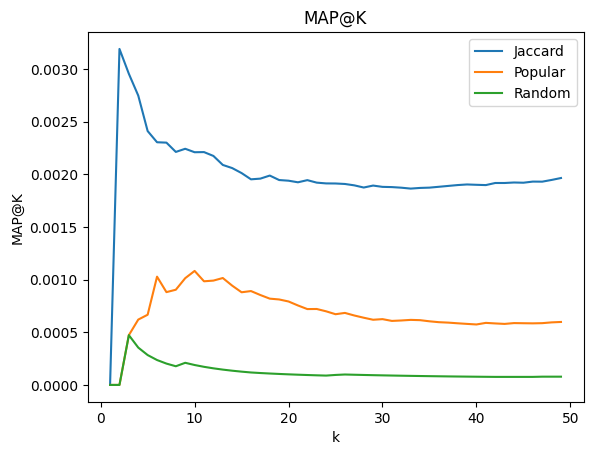

In [ ]:
mapsj = []
mapsp = []
mapsr = []
ks = range(1, 50)
recsj = User2User(train_ratings).get_test_recommendations(50)
recsp = poprec(train_ratings).get_test_recommendations(50)
recsr = randrec(train_ratings).get_test_recommendations(50)
for k in ks:
  mapsp.append(mapk(test_relevant, recsp, k))
  mapsr.append(mapk(test_relevant, recsr, k))
  mapsj.append(mapk(test_relevant, recsj, k))

fig, ax = plt.subplots()
plt.title('MAP@K')
ax.plot(ks, mapsj, label='Jaccard')
ax.plot(ks, mapsp, label='Popular')
ax.plot(ks, mapsr, label='Random')
plt.xlabel('k')
plt.ylabel('MAP@K')
plt.legend()
plt.show()

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [19]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import norm

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))
        self.R = csr_matrix((np.ones(len(self.ratings)), (self.ratings['userId'], self.ratings['trackId'])), shape = (self.n_users, self.n_items))

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for i in range(self.n_users):
            test_preds.append(self.recommend(i))
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds

In [ ]:
def jaccard(ratings: csr_matrix, user_vector: csr_matrix) -> np.array:
    up = ratings @ user_vector.T
    down = np.sum(user_vector) + ratings.sum(axis=1).A1 - up
    return np.array(up / down).flatten()

In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)
        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: csr_matrix):
        """
        user_vector: csr_matrix [1, n_items]
        """
        sim = self.similarity_func(self.R, user_vector)
        up = self.R[sim > self.alpha].multiply(sim[sim > self.alpha][:, np.newaxis]).sum(axis = 0)
        down = np.sum(np.abs(sim[sim > self.alpha]))
        return np.array(up / down).flatten()

    def recommend(self, uid: int):
        return np.argsort(-self.similarity(self.R[uid]))

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [20]:
user_id = np.random.randint(0, User2User(train_ratings).n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
10,Tutti Frutti,['Little Richard']
164,My Favourite Game,['The Cardigans']
226,Lovefool,['The Cardigans']
229,Linger,['The Cranberries']
234,Wind Of Change,['Scorpions']
369,Ameno,['Era']
370,Mother,['Era']
577,Mamma Mia,['ABBA']
581,Gimme! Gimme! Gimme! (A Man After Midnight),['ABBA']
590,The Day Before You Came,['ABBA']


In [ ]:
preds = User2User(train_ratings).get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
2814,Numb,['Linkin Park']
24500,Way Down We Go,['KALEO']
11493,The Show Must Go On,['Queen']
1073,Smells Like Teen Spirit,['Nirvana']
33436,Believer,['Imagine Dragons']
9694,We Will Rock You,['Queen']
1019,It's My Life,['Bon Jovi']
7533,Highway to Hell,['AC/DC']
53422,Dance Monkey,['Tones And I']
35064,Thunder,['Imagine Dragons']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
29974,"Не оставляй меня, любимый",['ВИА ГРА']
30666,"Girl, You'll Be a Woman Soon",['Urge Overkill']
32239,Не плачь,['Татьяна Буланова']
32243,Дальнобойщик,['Татьяна Овсиенко']
32773,How Deep Is Your Love,['Bee Gees']
32774,Stayin' Alive,['Bee Gees']
33095,Земля,['Маша и медведи']
33247,Музыкант,['Константин Никольский']
33260,Городок,['Анжелика Варум']
33261,"Художник, что рисует дождь",['Анжелика Варум']


### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.


$ P \in \mathbb{R}^{n \times k} $ - скрытые факторы юзера, $ Q \in \mathbb{R}^{m \times k}$ - скрытые факторы айтема, n - число юзеров, m - число факторов, k - размерность скрытых фактров.
# SGD
На каждой итерации для случайн овыбранного юзера и айтема, ошибка:
$e_{ui} = P_u Q_i^T - R_{ui}$, $R_{ui}$ - реальный рейтинг айтема от юзера.
Тогда:
$ Q_i = Q_i - 2 \eta \left( e_{ui} P_u + \lambda Q_i \right) $
<br>
$ P_u = P_u - 2 \eta \left( e_{ui} Q_i + \lambda P_u \right) $
<br>
$ \eta $ - лернинг рейт, $\lambda $ - регуляризация.

# ALS
1) Обновляем P, фиксируем Q:
Для каждого юзера:
$ Q_R $  - матрица со строками Q для айтемов, которые оценил юзер.
$ P_u = (Q_R^T Q_R + \lambda I)^{-1} Q_R^T R_{u*} $
,$R_{u*}$ - вектор с рейтингами для юзера u.

2) Обновляем Q, фиксируем P: То же самое
$Q_i = (P_R^T P_R + \lambda I)^{-1} P_R^T R_{*i} $

**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [155]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                self.sgd()
            elif self.mode == 'als':
                self.als()
                
    def sgd(self):
        user = np.random.randint(self.n_users)
        item = np.random.choice(np.where(self.R[user] != 0)[0])
        self.Q[item] -= 2 * self.lr * (self.P[user] * (self.Q[item] @ self.P[user]) - self.R[user, item] + self.lamb * self.Q[item])
        self.P[user] -= 2 * self.lr * (self.Q[item] * (self.Q[item] @ self.P[user]) - self.R[user, item] + self.lamb * self.P[user])

    def als(self):
        for user in range(self.n_users):
            nonzero = self.R[user] == 1
            if not nonzero.any(): # добавила тк иначе вылезала ошибка
                continue
            q = self.Q[nonzero]
            if q.shape[0] == 0: # добавила тк иначе вылезала ошибка
                continue
            self.P[user] = np.linalg.solve(q.T @ q + self.lamb * np.eye(self.dim), q.T @ self.R[user, nonzero])

        for item in range(self.n_items):
            nonzero = self.R[:, item] == 1
            if not nonzero.any():
                continue
            p = self.P[nonzero]
            if p.shape[0] == 0:
                continue
            self.Q[item] = np.linalg.solve(p.T @ p + self.lamb * np.eye(self.dim), p.T @ self.R[nonzero, item])

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T
        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

Метод als кажется более подхоядщим, у сгд явно есть какие-то проблемы)))

In [156]:
ks = [2, 4, 10]
dims = [10, 20, 40]
epochs = [2, 4, 6]
maps = []

for dim in dims:
    for epoch in epochs:
        model = LatentFactorModel(ratings = train_ratings, mode = 'als', dim = dim)
        model.fit(epoch)
        pred = model.get_test_recommendations(50)
        for k in ks:
            maps.append([dim, k, epoch, mapk(test_relevant, pred, k)])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [160]:
df = pd.DataFrame(maps, columns = ['Dimension', 'K', 'Epochs', 'MAP'])

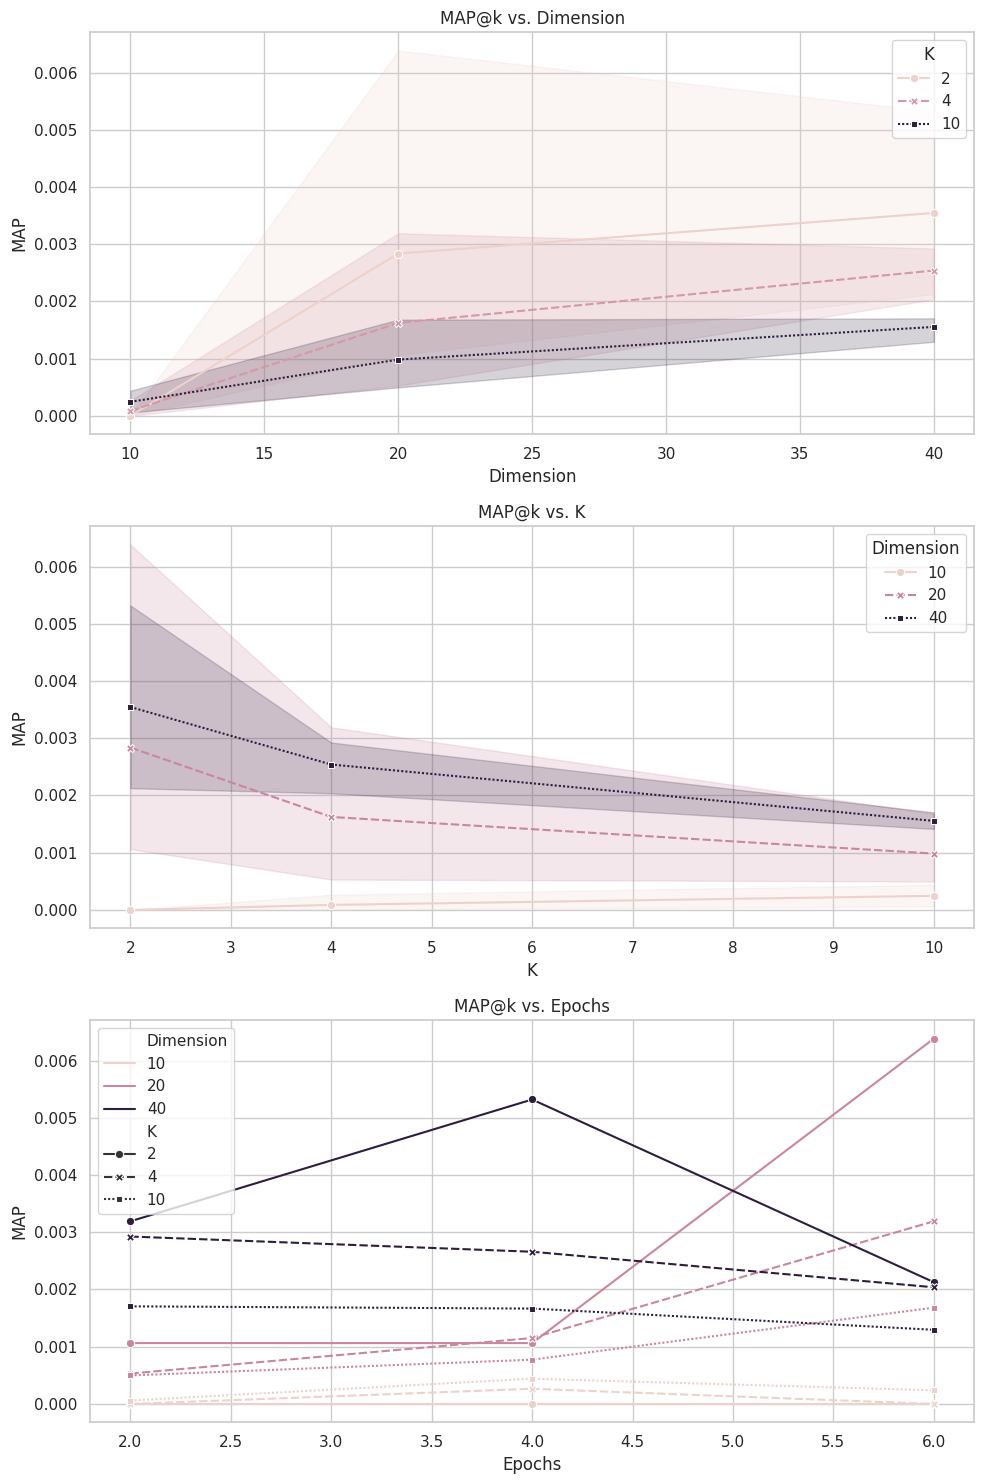

In [163]:
sns.set(style = 'whitegrid')
fig, axes = plt.subplots(3, 1, figsize = (10, 15))

sns.lineplot(data = df, x = 'Dimension', y = 'MAP', hue = 'K', style = 'K', markers = True, ax = axes[0])
axes[0].set_title('MAP@k vs. Dimension')

sns.lineplot(data = df, x = 'K', y = 'MAP', hue = 'Dimension', style = 'Dimension', markers = True, ax = axes[1])
axes[1].set_title('MAP@k vs. K')

sns.lineplot(data = df, x = 'Epochs', y = 'MAP', hue = 'Dimension', style = 'K', markers = True, ax = axes[2])
axes[2].set_title('MAP@k vs. Epochs')

plt.tight_layout()
plt.show()

In [157]:
dims = [10, 20, 40]
ks = [2, 4, 10]
epochs = [2, 4, 6]
mapssgd = []

for dim in dims:
    for epoch in epochs:
        model = LatentFactorModel(ratings = train_ratings, mode = 'sgd', dim = dim)
        model.fit(epoch)
        pred = model.get_test_recommendations(50)
        for k in ks:
            mapssgd.append([dim, k, epoch, mapk(test_relevant, pred, k)])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [164]:
df = pd.DataFrame(mapssgd, columns = ['Dimension', 'K', 'Epochs', 'MAP'])

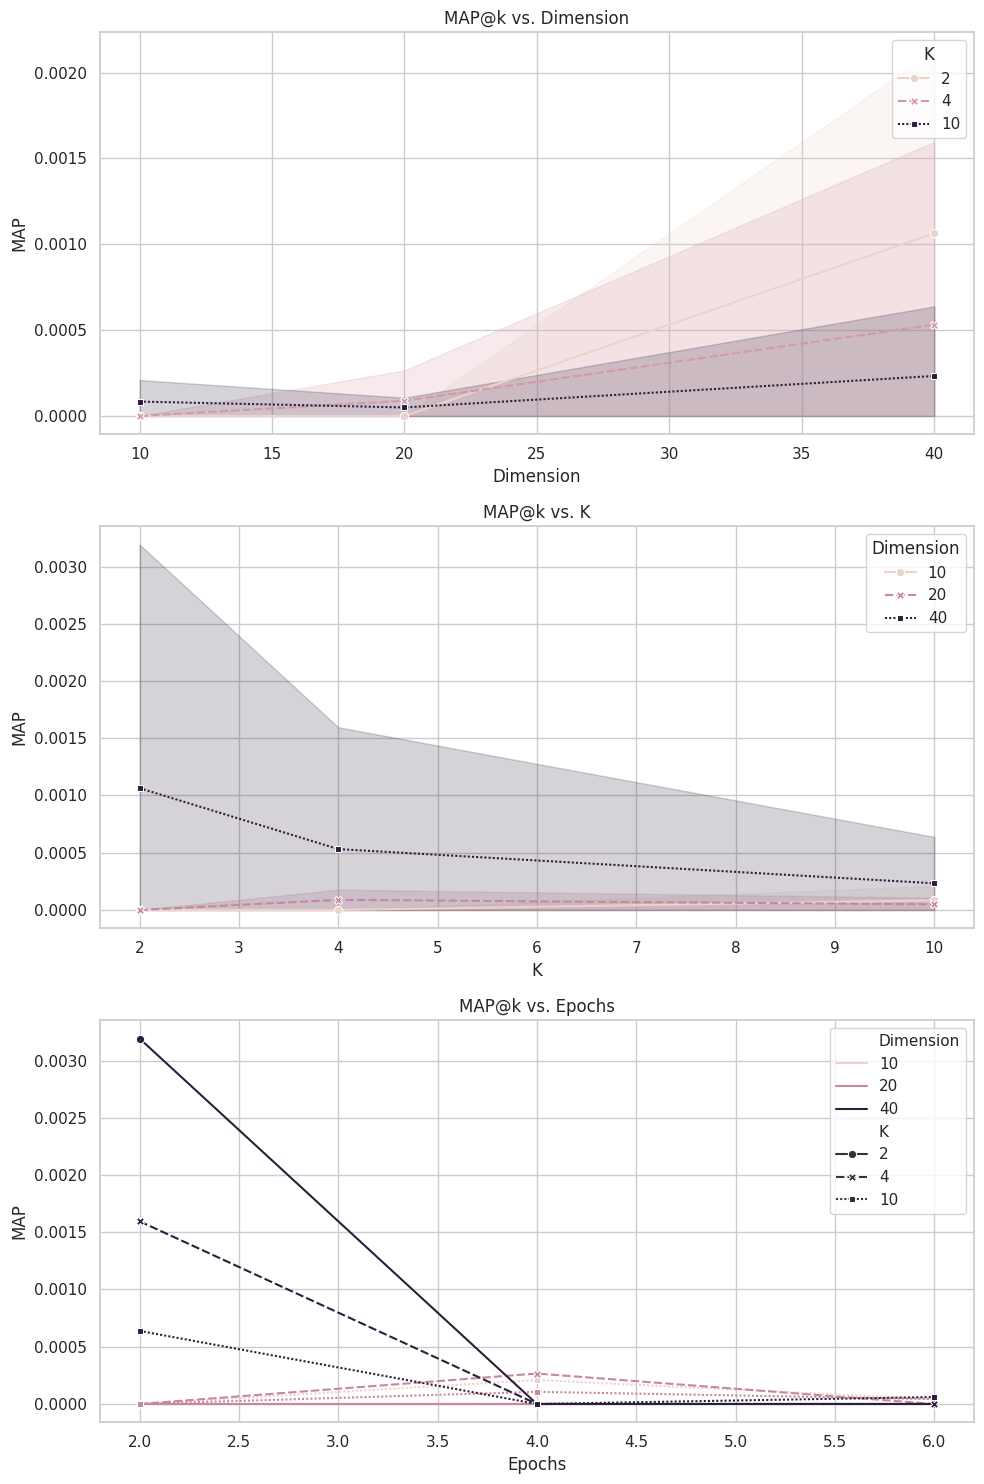

In [165]:
sns.set(style = 'whitegrid')
fig, axes = plt.subplots(3, 1, figsize = (10, 15))

sns.lineplot(data = df, x = 'Dimension', y = 'MAP', hue = 'K', style = 'K', markers = True, ax = axes[0])
axes[0].set_title('MAP@k vs. Dimension')

sns.lineplot(data = df, x = 'K', y = 'MAP', hue = 'Dimension', style = 'Dimension', markers = True, ax = axes[1])
axes[1].set_title('MAP@k vs. K')

sns.lineplot(data = df, x = 'Epochs', y = 'MAP', hue = 'Dimension', style = 'K', markers = True, ax = axes[2])
axes[2].set_title('MAP@k vs. Epochs')

plt.tight_layout()
plt.show()

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
5517,Варвара,['Би-2'],0.649796
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.646846
2058,Последний герой,['КИНО'],0.640997
5872,Я свободен,['Кипелов'],0.606749
2060,Хочу перемен,['КИНО'],0.603231
5515,Романс,['Сплин'],0.590318
24284,Как на войне,['Агата Кристи'],0.586219
4463,Holiday,['Green Day'],0.576644
2179,Восьмиклассница,['КИНО'],0.570639


**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

Идея взята отсюда: https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe
Обозначения могут совпадать, но я писала сама!!


Оно обучалось очень долго....сравнить не получилось(

In [ ]:
class LatentFactorModel2(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd', alpha=40):
        super().__init__(ratings)
        self.dim = dim
        self.mode = mode
        self.alpha = alpha

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'ials':
                self.ials()

    def ials(self):
        C = 1 + self.alpha * self.R
        for user in range(self.n_users):
            Cu = np.diag(C[user])
            self.P[user] = np.linalg.solve(self.Q.T @ Cu @ self.Q + self.lamb * np.eye(self.dim), self.Q.T @ Cu @ self.R[user])

        for item in range(self.n_items):
            Ci = np.diag(C[:, item])
            self.Q[item] = np.linalg.solve(self.P.T @ Ci @ self.P + self.lamb * np.eye(self.dim), self.P.T @ Ci @ self.R[:, item])

    def recommend(self, uid):
        return np.argsort(self.P[uid] @ self.Q.T)[::-1]

model = LatentFactorModel2(train_ratings, mode = 'ials')
model.fit(num_iters=10)

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [23]:
lfm = LatentFactorModel(train_ratings, dim = 32, mode = 'sgd')
lfm.fit(num_iters = 10)
reclfm = lfm.get_test_recommendations(100)

u2u = User2User(train_ratings)
recu2u = u2u.get_test_recommendations(100)

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
tracks_info.loc[reclfm[0]][['name', 'artists']]

,name,artists
55705,"1, 2",['Tanir & Tyomcha']
7359,8 Mile,['Eminem']
31839,Женщина моя,['Храмыч']
3929,I Against I,"['Massive Attack', 'Mos Def']"
41572,"Concerto in g minor for violin, string orchest...",['Antonio Vivaldi']
...,...,...
34923,Ill Ray (The King),['Kasabian']
47130,Я не прощаю,['Mary Gu']
44209,Before I Leave This World,['Ivan Torrent']
59468,Маяк,['Звонкий']


In [28]:
tracks_info.loc[recu2u[0]][['name', 'artists']]

,name,artists
4507,I Wanna Rock,['Twisted Sister']
724,Kickstart My Heart,['Mötley Crüe']
6441,Cum on Feel the Noize,['Quiet Riot']
38044,Fortunate Son,['Creedence Clearwater Revival']
30300,Blitzkrieg Bop,['Ramones']
...,...,...
25273,Enjoy the Silence,['Lacuna Coil']
11485,I Want To Break Free,['Queen']
2820,Somewhere I Belong,['Linkin Park']
755,Rollin' (Air Raid Vehicle),['Limp Bizkit']


In [29]:
df_reclfm = pd.DataFrame(reclfm)
df_recu2u = pd.DataFrame(recu2u)

In [30]:
res = []

In [31]:
for i in range(len(df_reclfm)):
    res.append(pd.concat([df_reclfm.iloc[i], df_recu2u.iloc[i]]).unique())

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

In [54]:
user_item_pairs = []
for uid in range(len(res)):
    for iid in res[uid]:
        features = {
            "user_id": uid,
            "item_id": iid,
            "cosine_distance": cosine_similarity(lfm.P[uid].reshape(1, -1), lfm.Q[iid].reshape(1, -1))[0, 0],
            "user_perc": np.mean(train_ratings['trackId'] == iid),
            "item_count": np.sum(train_ratings['userId'] == uid),
            "target": (test_ratings.loc[test_ratings['userId'] == uid, 'trackId'].tail(50) == iid).any().astype(int)
        }
        user_item_pairs.append(features)
df = pd.DataFrame(user_item_pairs)

In [56]:
jacs = []
for uid in range(len(recu2u)):
  all_sims = u2u.similarity_func(u2u.R, u2u.R[uid])
  sims = np.delete(all_sims, uid)
  jacs.append(np.mean(sims))

In [57]:
jacsd = dict(enumerate(jacs))
df['jaccard_similarity'] = df['user_id'].map(jacsd)

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
train_df, test_df = train_test_split(df, test_size = 2/5, random_state = 42, stratify = df['target'])

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ).

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [ ]:
import catboost

In [127]:
X_train = train_df.drop('target', axis = 1).sort_values(by = 'user_id')
y_train = train_df['target'][X_train.index]
X_test = test_df.drop('target', axis = 1).sort_values(by = 'user_id')
y_test = test_df['target'][X_test.index]

train_pool = catboost.Pool(X_train, y_train, group_id = train_df['user_id'][X_train.index])
test_pool = catboost.Pool(X_test, y_test, group_id = test_df['user_id'][X_test.index])

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [69]:
from catboost import CatBoostClassifier

In [70]:
model = CatBoostClassifier(iterations = 1000, learning_rate = 0.1, depth = 6, loss_function = 'Logloss')
model.fit(train_pool)

0:	learn: 0.4133179	total: 58ms	remaining: 57.9s
1:	learn: 0.2493554	total: 80.2ms	remaining: 40s
2:	learn: 0.1542185	total: 95.7ms	remaining: 31.8s
3:	learn: 0.1011526	total: 107ms	remaining: 26.5s
4:	learn: 0.0669983	total: 115ms	remaining: 23s
5:	learn: 0.0478665	total: 124ms	remaining: 20.6s
6:	learn: 0.0359303	total: 133ms	remaining: 18.9s
7:	learn: 0.0282111	total: 142ms	remaining: 17.6s
8:	learn: 0.0225729	total: 151ms	remaining: 16.6s
9:	learn: 0.0187833	total: 160ms	remaining: 15.8s
10:	learn: 0.0162637	total: 169ms	remaining: 15.2s
11:	learn: 0.0146390	total: 178ms	remaining: 14.7s
12:	learn: 0.0135457	total: 203ms	remaining: 15.4s
13:	learn: 0.0126001	total: 214ms	remaining: 15.1s
14:	learn: 0.0118574	total: 223ms	remaining: 14.6s
15:	learn: 0.0113558	total: 232ms	remaining: 14.2s
16:	learn: 0.0110364	total: 240ms	remaining: 13.9s
17:	learn: 0.0107663	total: 251ms	remaining: 13.7s
18:	learn: 0.0103809	total: 264ms	remaining: 13.6s
19:	learn: 0.0100829	total: 273ms	remaining:

In [108]:
probs = model.predict_proba(test_pool)[:, 1]

Там получилось какое-то месиво, нужно это переделать в нормальный вид

In [ ]:
d = {}

In [ ]:
for id, group in enumerate(test_df['user_id'][X_test.index].to_numpy()):
    if group not in d:
        d[group] = {'true': [], 'probs': []}
    d[group]['true'].append(y_test.to_numpy()[id])
    d[group]['probs'].append(probs[id])

In [ ]:
real, preds = [], []

In [123]:
for group in d:
    real.append(np.where(np.array(d[group]['true']) == 1)[0].tolist())
    preds.append(np.argsort(-np.array(d[group]['probs']))[:20].tolist())
mapk(real, preds)

0.23048534233488985

In [138]:
recsj = User2User(train_ratings).get_test_recommendations(20)
mapk(test_relevant, recsj, 20)

0.0019398188030853862

In [139]:
lfm = LatentFactorModel(train_ratings, dim = 32, mode = 'sgd')
lfm.fit(num_iters = 10)
reclfm = lfm.get_test_recommendations(20)
mapk(test_relevant, reclfm)

  0%|          | 0/10 [00:00<?, ?it/s]

9.599797365754812e-05

все сломалось..

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [141]:
from catboost import CatBoostRanker

In [147]:
model = CatBoostRanker(iterations = 1000, learning_rate = 0.1, depth = 6, loss_function = 'PairLogit')
model.fit(train_pool)
preds = [list(np.argsort(-probs)[:20]) for probs in model.predict(test_pool).reshape(-1, 1)]
rel = [np.where(y_test.to_numpy() == 1)[0].tolist() for i in range(len(preds))]
mapk(rel, preds, k = 20)

0:	learn: 0.5333335	total: 39.4ms	remaining: 39.3s
1:	learn: 0.4072982	total: 83.2ms	remaining: 41.5s
2:	learn: 0.3337373	total: 129ms	remaining: 42.9s
3:	learn: 0.2754507	total: 189ms	remaining: 47s
4:	learn: 0.2291803	total: 220ms	remaining: 43.8s
5:	learn: 0.1938541	total: 287ms	remaining: 47.5s
6:	learn: 0.1632670	total: 349ms	remaining: 49.5s
7:	learn: 0.1496006	total: 411ms	remaining: 50.9s
8:	learn: 0.1344045	total: 472ms	remaining: 52s
9:	learn: 0.1261843	total: 521ms	remaining: 51.6s
10:	learn: 0.1132730	total: 584ms	remaining: 52.5s
11:	learn: 0.1079739	total: 632ms	remaining: 52s
12:	learn: 0.0994795	total: 686ms	remaining: 52.1s
13:	learn: 0.0962871	total: 744ms	remaining: 52.4s
14:	learn: 0.0902131	total: 802ms	remaining: 52.6s
15:	learn: 0.0834145	total: 861ms	remaining: 53s
16:	learn: 0.0770637	total: 918ms	remaining: 53.1s
17:	learn: 0.0736490	total: 988ms	remaining: 53.9s
18:	learn: 0.0676693	total: 1.05s	remaining: 54.2s
19:	learn: 0.0643252	total: 1.11s	remaining: 54

0.0